# Reproduction rate

Here, the reproducation rate is computed using the [logistic map](https://en.wikipedia.org/wiki/Logistic_map):



Solving for r, I [got](https://www.wolframalpha.com/input/?i=Solve+n%28t%2B1%29+%3D+r*n%28t%29*%281-n%28t%29%29+for+r) `r = n(t+1) / (n(t)-n²(t))`.

*Data*: [@entorb](https://github.com/entorb/COVID-19-Coronavirus-German-Regions)'s dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

def polynomial_r(df, population = 81e6, generation_time=4):
    rs = pd.DataFrame()
    for col in ['Deaths', 'Cases']:
        normalized = df[col] / population
        earlier = normalized.shift(generation_time)
        rs[col] = normalized / (earlier - earlier**2)
    return rs

def rki_r(df, generation_time=4):
    rs = pd.DataFrame()
    for col in ['Deaths', 'Cases']:
        rolled = df[col+'_New'].rolling("%dD" % generation_time).sum()
        earlier = rolled.shift(generation_time)
        rs[col] = rolled / earlier
    return rs
    

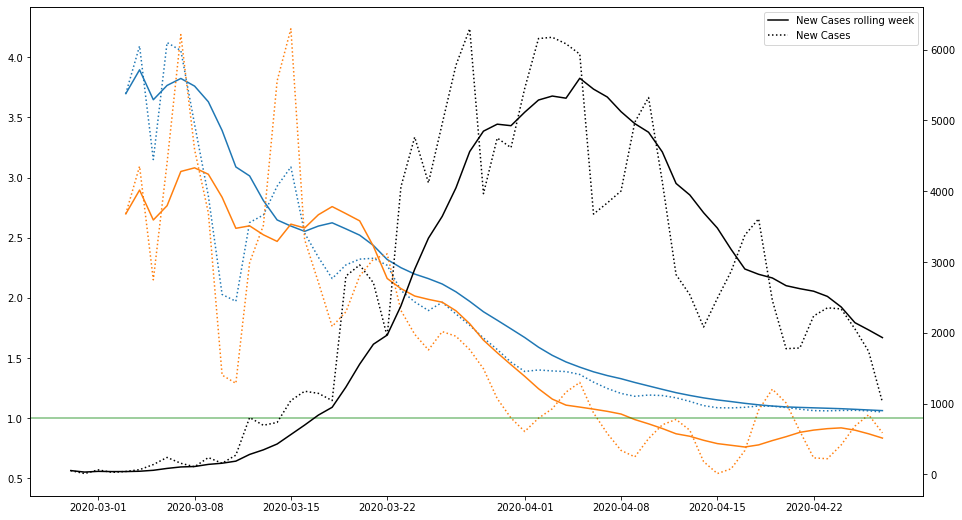

In [2]:
import numpy as np

de = entorb.to_dataframe('DE-total')

fig, ax = plt.subplots()
ax2 = ax.twinx()

l = ax2.plot(de.index, de['Cases_New'].rolling('7D').mean(), color='k', label='New Cases rolling week')
ax2.plot(de.index, de['Cases_New'], linestyle=':', color=l[0].get_color(), label='New Cases')

poly = polynomial_r(de)['Cases']
l = ax.plot(de.index, poly.rolling('7D').mean(), label='Logistic rolling week')
ax.plot(de.index, poly, linestyle=':', color=l[0].get_color(), label='Logistic')

rki = rki_r(de)['Cases']
l = ax.plot(de.index, rki.rolling('7D').mean(), label='RKI rolling week')
ax.plot(de.index, rki, linestyle=':', color=l[0].get_color(), label='RKI')

plt.legend()
ax.axhline(1.0, color='g', alpha=0.5)
fig.set_size_inches(16,9)

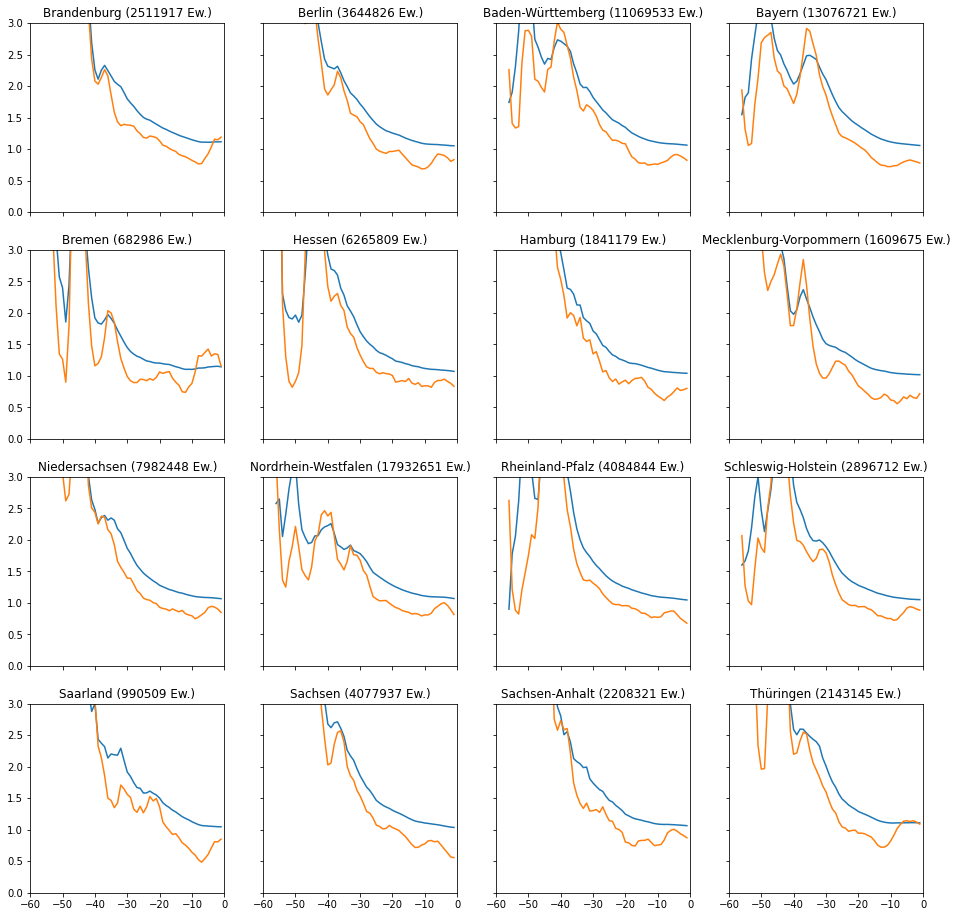

In [3]:
from scrape.scrape import federal_state_translation as fst
from matplotlib import dates as mdates

population = {
    'Baden-Württemberg': 11069533,
    'Bayern': 13076721,
    'Berlin': 3644826,
    'Brandenburg': 2511917,
    'Bremen': 682986,
    'Hamburg': 1841179,
    'Hessen': 6265809,
    'Mecklenburg-Vorpommern': 1609675,
    'Niedersachsen': 7982448,
    'Nordrhein-Westfalen': 17932651,
    'Rheinland-Pfalz': 4084844,
    'Saarland': 990509,
    'Sachsen': 4077937,
    'Sachsen-Anhalt': 2208321,
    'Schleswig-Holstein': 2896712,
    'Thüringen': 2143145,
}

def plot_r(col='Cases', ncols=4):
    lasts = []
    lasts_rki = []
    areas = sorted([x for x in fst])
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)
    for i, (ax, area) in enumerate(zip(axes.flat, areas)):
        de = entorb.to_dataframe(area).rolling('7D').mean()
        
        rs = polynomial_r(de, population[fst[area]])
        lasts.append(rs.last('1D').mean()[col])
        
        ax.plot(range(-len(rs.index), 0), rs[col])
        ax.set_title("%s (%d Ew.)" % (fst[area], population[fst[area]]))
        ax.set_xlabel('')
        ax.set_xlim(-len(rs.index), 0)
        ax.set_ylim(0, 3)
        
        rs = rki_r(de)
        lasts_rki.append(rs.last('1D').mean()[col])
        
        ax.plot(range(-len(rs.index), 0), rs[col])
        
    fig.set_size_inches(16,16)
    fig.set_facecolor('w')
    return lasts, lasts_rki

lasts, lasts_rki = plot_r()

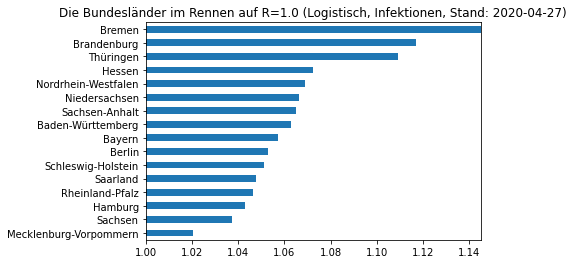

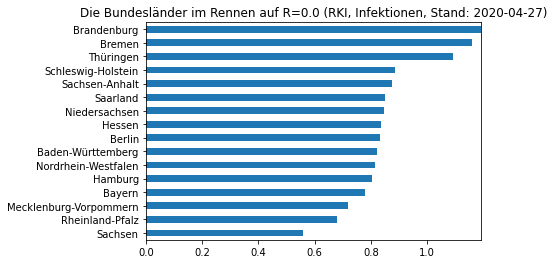

In [4]:
from datetime import datetime

current_r = pd.DataFrame({'Logistic': lasts}, index=[fst[x] for x in sorted([y for y in fst])])
current_r.sort_values('Logistic').plot(kind='barh',
               xlim=(min(1.0, min(lasts)), max(lasts)),
               legend=False, grid=False,
               title="Die Bundesländer im Rennen auf R=1.0 (Logistisch, Infektionen, Stand: %s)" % (datetime.now().strftime('%Y-%m-%d')))

current_r = pd.DataFrame({'RKI': lasts_rki}, index=[fst[x] for x in sorted([y for y in fst])])
current_r.sort_values('RKI').plot(kind='barh',
               xlim=(min(0.0, min(lasts_rki)), max(lasts_rki)),
               legend=False, grid=False,
               title="Die Bundesländer im Rennen auf R=0.0 (RKI, Infektionen, Stand: %s)" % (datetime.now().strftime('%Y-%m-%d')))

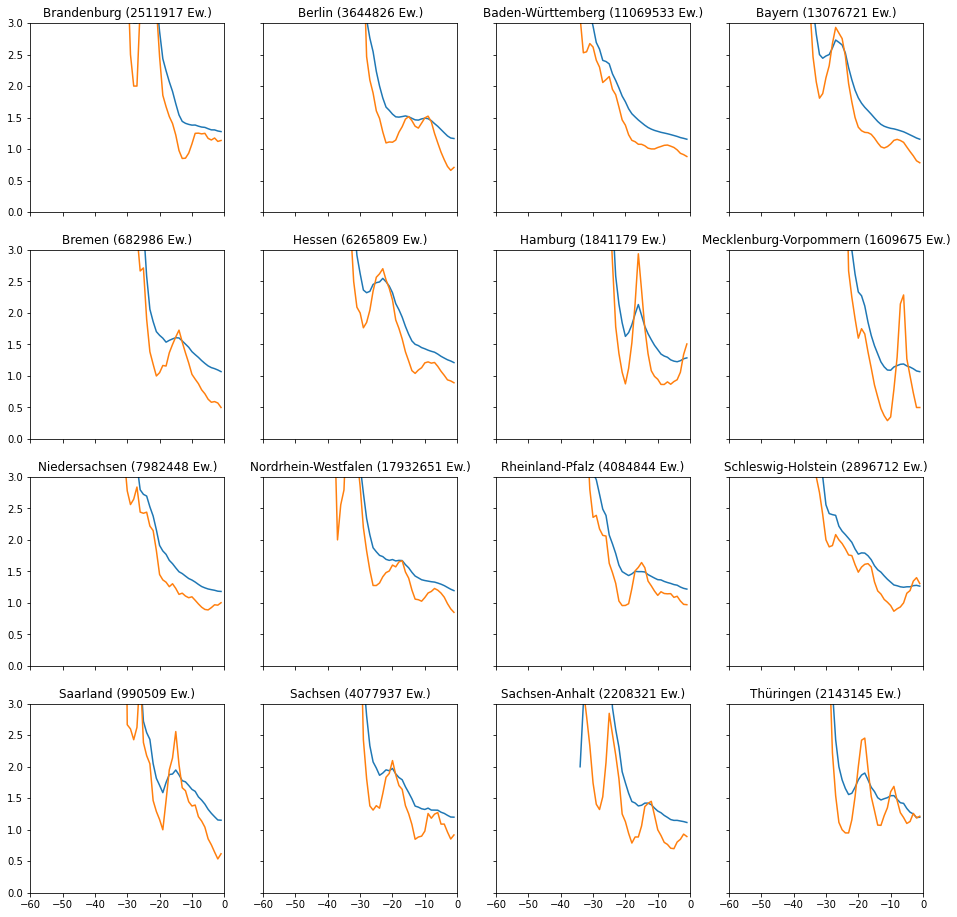

In [5]:
lasts, lasts_rki = plot_r(col='Deaths')

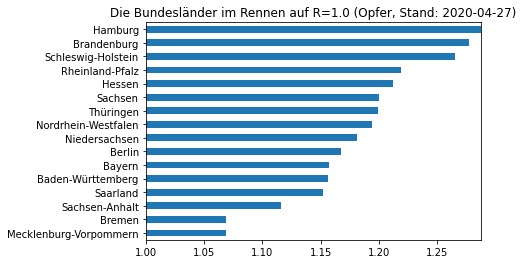

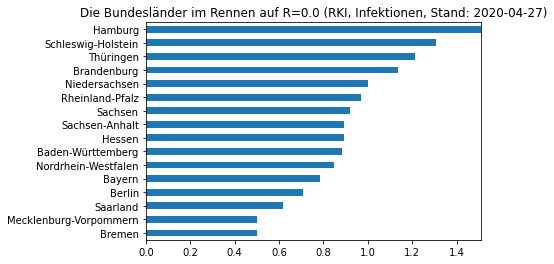

In [6]:
from datetime import datetime

current_r = pd.DataFrame({'R': lasts}, index=[fst[x] for x in sorted([y for y in fst])])
current_r.sort_values('R').plot(kind='barh',
               xlim=(min(1.0, min(lasts)), max(lasts)),
               legend=False, grid=False,
               title="Die Bundesländer im Rennen auf R=1.0 (Opfer, Stand: %s)" % (datetime.now().strftime('%Y-%m-%d')))

current_r = pd.DataFrame({'RKI': lasts_rki}, index=[fst[x] for x in sorted([y for y in fst])])
current_r.sort_values('RKI').plot(kind='barh',
               xlim=(min(0.0, min(lasts_rki)), max(lasts_rki)),
               legend=False, grid=False,
               title="Die Bundesländer im Rennen auf R=0.0 (RKI, Infektionen, Stand: %s)" % (datetime.now().strftime('%Y-%m-%d')))

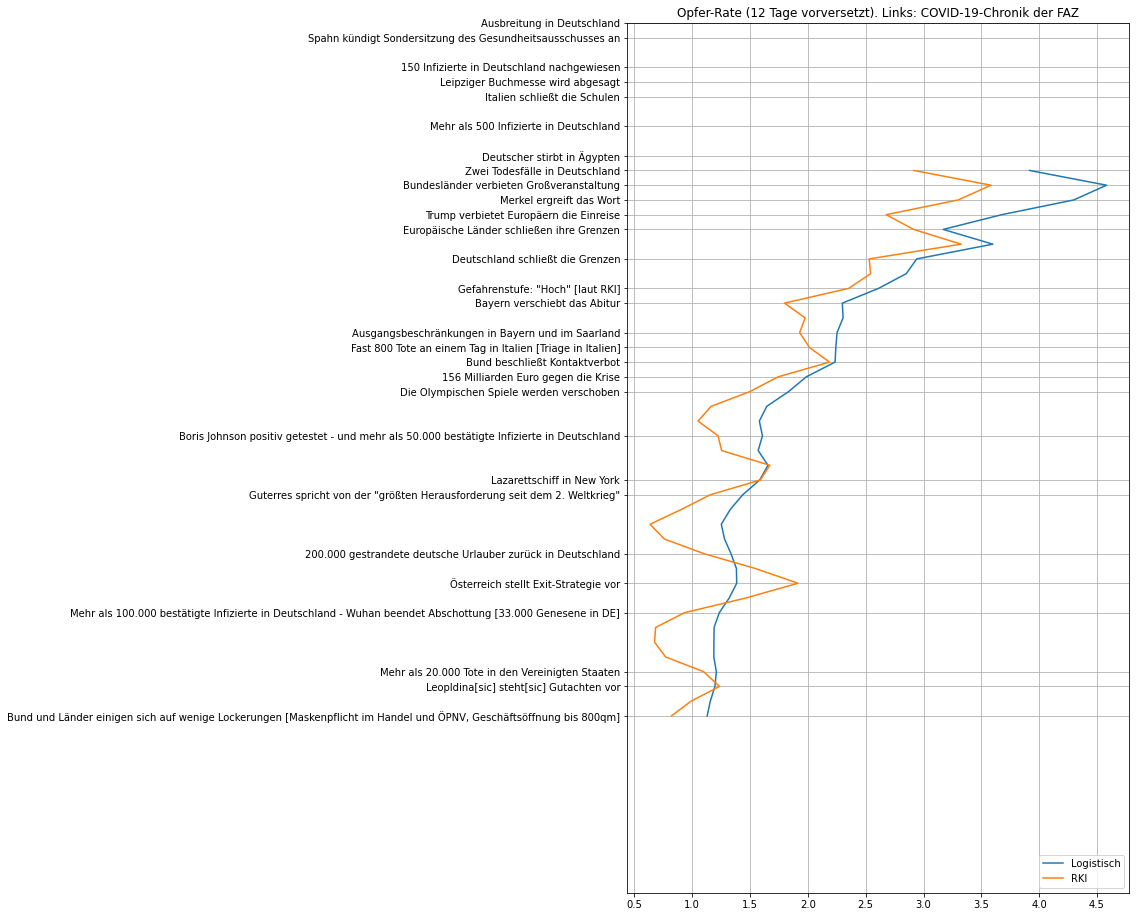

In [7]:
de = entorb.to_dataframe('DE-total')
rs1 = polynomial_r(de)
rs2 = rki_r(de)
news = pd.read_csv('data/chronic_de.tsv', sep="\t", usecols=['Datum', 'Ereignis'])
news['Datum'] = pd.to_datetime(news['Datum'], format='%Y-%m-%d')
news = news.set_index('Datum')
dt = 12
shifted1 = rs1['Deaths'].shift(-dt)
shifted2 = rs2['Deaths'].shift(-dt)
fig, ax = plt.subplots()
ax.plot(shifted1, shifted1.index, label='Logistisch')
ax.plot(shifted2, shifted2.index, label='RKI')
ax.set_title("Opfer-Rate (%d Tage vorversetzt). Links: COVID-19-Chronik der FAZ" % dt)
ax.set_yticks(news.index)
ax.set_ylim(shifted1.index.max(), shifted1.index.min())
ax.set_yticklabels(news['Ereignis'])
ax.grid()
fig.set_size_inches(9,16)
plt.legend(loc='lower right')
t = ax.set_ylabel('')